In [141]:
import torch 
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [142]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

In [143]:
train_ds, val_ds = random_split(dataset,(48000, 12000))

In [144]:
test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [145]:
batch_size = 32

In [146]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

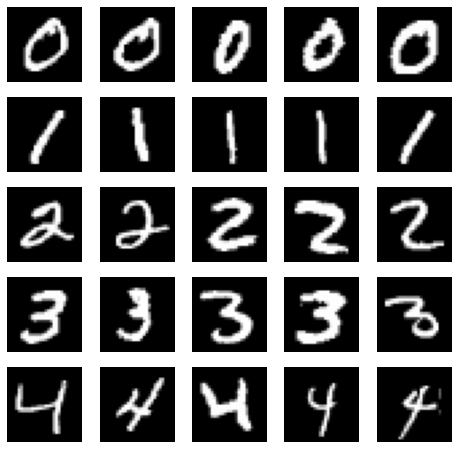

In [147]:
class_images = {i: [] for i in range(10)}

for i in range(len(dataset)):
    image, label = dataset[i]
    if len(class_images[label]) < 5:
        class_images[label].append(image)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(class_images[i][j].squeeze(), cmap='gray')
        axs[i,j].axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.Softmax()(x)
        return x

# a = Model()
# print(a(torch.randn(1,1,28,28)))


In [ ]:
lr = 0.0001
epochs = 20
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
Softmax = nn.Softmax(dim=1)

In [148]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    
    # plot losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # plot accuracies
    axs[1].plot(train_accs, label='Training Accuracy')
    axs[1].plot(val_accs, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

<ipython-input-22-9778578c92c8>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.Softmax()(x)


Epoch - 0 :  Loss - 42.89, Accuracy - 78.125%
Epoch - 0 : Validation Loss - 1.6665852069854736, Validation Accuracy - 81.0583
Epoch - 1 :  Loss - 38.6379, Accuracy - 87.5%
Epoch - 1 : Validation Loss - 1.6201435327529907, Validation Accuracy - 83.0583
Epoch - 2 :  Loss - 38.1607, Accuracy - 78.125%
Epoch - 2 : Validation Loss - 1.663641333580017, Validation Accuracy - 84.1083
Epoch - 3 :  Loss - 37.8729, Accuracy - 81.25%
Epoch - 3 : Validation Loss - 1.5365628004074097, Validation Accuracy - 84.8833
Epoch - 4 :  Loss - 37.4825, Accuracy - 90.625%
Epoch - 4 : Validation Loss - 1.5332741737365723, Validation Accuracy - 93.475
Epoch - 5 :  Loss - 35.7252, Accuracy - 93.75%
Epoch - 5 : Validation Loss - 1.5207345485687256, Validation Accuracy - 94.775
Epoch - 6 :  Loss - 35.4767, Accuracy - 96.875%
Epoch - 6 : Validation Loss - 1.4932986497879028, Validation Accuracy - 95.0833
Epoch - 7 :  Loss - 35.3293, Accuracy - 100.0%
Epoch - 7 : Validation Loss - 1.5309339761734009, Validation Accur

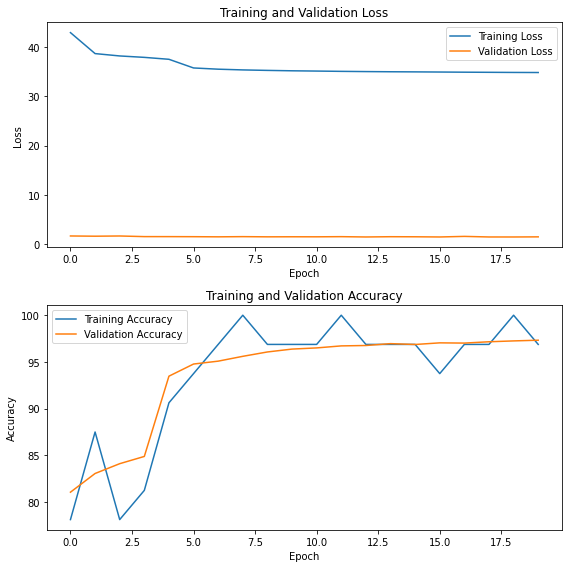

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_dl, 0):

        data2, labels = data[0], data[1]
        optimizer.zero_grad()
        output = model(torch.Tensor(data2))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predict = torch.argmax(Softmax(output),dim=1)
        correct=torch.sum(torch.eq(predict,labels)) 
        total = labels.size(0)
        correct += correct.item()
        total += total

    train_losses.append(running_loss/total)
    train_accs.append(100*correct/total)
            
    accuracy=100*correct/total
    print(f"Epoch - {epoch} :  Loss - {round(running_loss/total ,4)}, Accuracy - {accuracy}%")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Setup-1/epoch_{epoch}.pt")
    
    with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in val_dl:
            
            vsample += len(vdata)
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            vcorrect += torch.eq(Softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        val_losses.append(vloss)
        val_accs.append((vcorrect/vsample)*100)

        
    print(f"Epoch - {epoch} : Validation Loss - {vloss}, Validation Accuracy - {round((vcorrect/vsample)*100, 4)}")


plot_metrics(train_losses, val_losses, train_accs, val_accs)


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Setup-1/epoch_18.pt"))

with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in test_dl:
            
            vsample += len(vdata)
            
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            
            vcorrect += torch.eq(Softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        
print(f"Test Accuracy - {round((vcorrect/vsample)*100, 4)}")

<ipython-input-22-9778578c92c8>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.Softmax()(x)


Test Accuracy - 97.86


In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(20 * 7 * 7, 50)
        self.out = nn.Linear(784, 10)

    def forward(self, x):
        identity_out = x
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 20 * 7 * 7)
        out = F.relu(self.fc(out))
        x = out
        output_size = 784
        padding_size = output_size - x.size(1)
        padded_x = torch.nn.functional.pad(x, (0, padding_size))
        out=padded_x
        out += identity_out.view(-1, 784)
        out = F.relu(out)
        out = self.out(out)

        return out

In [152]:
lr = 0.0001
epochs = 20
model = Net2()
Softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch - 0 :  Loss - 16.3172, Accuracy - 90.625%
Epoch - 0 : Validation Loss - 0.2307969182729721, Validation Accuracy - 89.9
Epoch - 1 :  Loss - 6.3803, Accuracy - 90.625%
Epoch - 1 : Validation Loss - 0.20860408246517181, Validation Accuracy - 93.2417
Epoch - 2 :  Loss - 4.5962, Accuracy - 93.75%
Epoch - 2 : Validation Loss - 0.15789946913719177, Validation Accuracy - 94.8083
Epoch - 3 :  Loss - 3.5296, Accuracy - 93.75%
Epoch - 3 : Validation Loss - 0.07448993623256683, Validation Accuracy - 95.9417
Epoch - 4 :  Loss - 2.8288, Accuracy - 93.75%
Epoch - 4 : Validation Loss - 0.0598374605178833, Validation Accuracy - 96.5917
Epoch - 5 :  Loss - 2.3898, Accuracy - 100.0%
Epoch - 5 : Validation Loss - 0.027355603873729706, Validation Accuracy - 97.3083
Epoch - 6 :  Loss - 2.0765, Accuracy - 96.875%
Epoch - 6 : Validation Loss - 0.10521627962589264, Validation Accuracy - 97.2167
Epoch - 7 :  Loss - 1.8487, Accuracy - 96.875%
Epoch - 7 : Validation Loss - 0.018741874024271965, Validation A

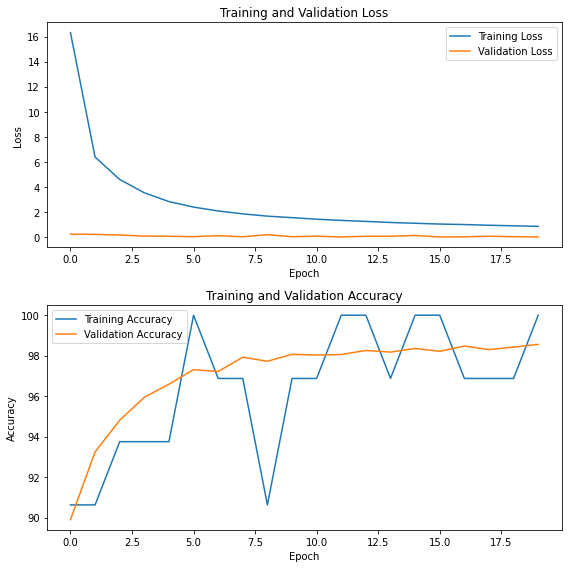

In [153]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []


torch.autograd.set_detect_anomaly(True)


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_dl, 0):

        data2, labels = data[0], data[1]
        optimizer.zero_grad()
        output = model(torch.Tensor(data2))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predict = torch.argmax(Softmax(output),dim=1)
        correct=torch.sum(torch.eq(predict,labels)) 
        total = labels.size(0)
        correct += correct.item()
        total += total

      
    train_losses.append(running_loss/total)
    train_accs.append(100*correct/total)
        
    accuracy=100*correct/total
    print(f"Epoch - {epoch} :  Loss - {round(running_loss/total ,4)}, Accuracy - {accuracy}%")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Setup-2/epoch_{epoch}.pt")
    
    with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in val_dl:
            
            vsample += len(vdata)
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            vcorrect += torch.eq(Softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        val_losses.append(vloss)
        val_accs.append((vcorrect/vsample)*100)
        
    print(f"Epoch - {epoch} : Validation Loss - {vloss}, Validation Accuracy - {round((vcorrect/vsample)*100, 4)}")



plot_metrics(train_losses, val_losses, train_accs, val_accs)


In [154]:
model=Net2()
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)


model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Setup-2/epoch_19.pt"))

with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in test_dl:
            
            vsample += len(vdata)
            
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            
            vcorrect += torch.eq(softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        
print(f"Test Accuracy - {round((vcorrect/vsample)*100, 4)}")

Test Accuracy - 98.66


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.residual_conv = nn.Conv2d(20, 20, kernel_size=1)
        self.residual = nn.Sequential(
            nn.Conv2d(20, 20, kernel_size=5, padding=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 20, kernel_size=5, padding=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        residual = self.residual_conv(x)
        x = self.residual(x)
        x = x.clone() + residual
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = nn.Softmax(dim=1)(x)
        return x


In [156]:
lr = 0.0001
epochs = 20
model = Net()
Softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch - 0 :  Loss - 38.3429, Accuracy - 93.75%
Epoch - 0 : Validation Loss - 1.5289007425308228, Validation Accuracy - 97.0583
Epoch - 1 :  Loss - 34.9984, Accuracy - 96.875%
Epoch - 1 : Validation Loss - 1.5222840309143066, Validation Accuracy - 97.6417
Epoch - 2 :  Loss - 34.7834, Accuracy - 96.875%
Epoch - 2 : Validation Loss - 1.4697928428649902, Validation Accuracy - 98.1167
Epoch - 3 :  Loss - 34.6633, Accuracy - 100.0%
Epoch - 3 : Validation Loss - 1.489333152770996, Validation Accuracy - 98.0667
Epoch - 4 :  Loss - 34.5964, Accuracy - 100.0%
Epoch - 4 : Validation Loss - 1.4933322668075562, Validation Accuracy - 98.2667
Epoch - 5 :  Loss - 34.5402, Accuracy - 100.0%
Epoch - 5 : Validation Loss - 1.4648711681365967, Validation Accuracy - 98.3583
Epoch - 6 :  Loss - 34.5098, Accuracy - 100.0%
Epoch - 6 : Validation Loss - 1.4667344093322754, Validation Accuracy - 98.5667
Epoch - 7 :  Loss - 34.478, Accuracy - 100.0%
Epoch - 7 : Validation Loss - 1.4639782905578613, Validation Acc

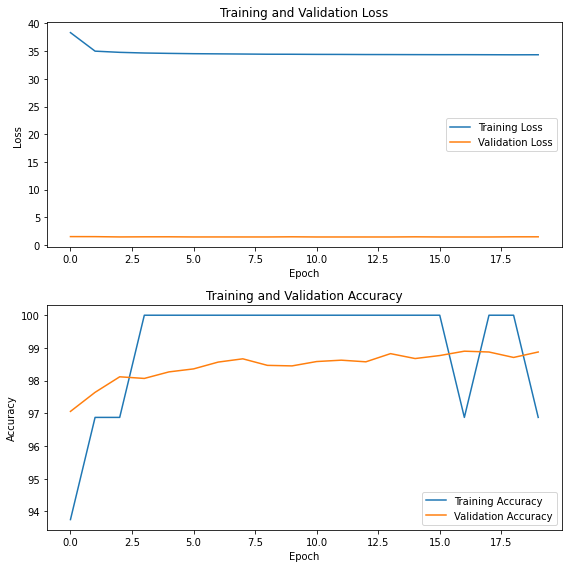

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []


torch.autograd.set_detect_anomaly(True)


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_dl, 0):

        data2, labels = data[0], data[1]
        optimizer.zero_grad()
        output = model(torch.Tensor(data2))
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predict = torch.argmax(Softmax(output),dim=1)
        correct=torch.sum(torch.eq(predict,labels)) 
        total = labels.size(0)
        correct += correct.item()
        total += total

      
    train_losses.append(running_loss/total)
    train_accs.append(100*correct/total)
        
    accuracy=100*correct/total
    print(f"Epoch - {epoch} :  Loss - {round(running_loss/total ,4)}, Accuracy - {accuracy}%")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Setup-2/epoch_{epoch}.pt")
    
    with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in val_dl:
            
            vsample += len(vdata)
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            vcorrect += torch.eq(Softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        val_losses.append(vloss)
        val_accs.append((vcorrect/vsample)*100)
        
    print(f"Epoch - {epoch} : Validation Loss - {vloss}, Validation Accuracy - {round((vcorrect/vsample)*100, 4)}")



plot_metrics(train_losses, val_losses, train_accs, val_accs)


In [159]:
model=Net()
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)


model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment-2/ckpts/Copy of epoch_16.pt"))

with torch.no_grad():
        model.eval()

        vsample, vcorrect = 0, 0
        for vdata, vlabel in test_dl:
            
            vsample += len(vdata)
            
            vpreds = model(vdata)
            vloss = criterion(vpreds, vlabel)
            
            vcorrect += torch.eq(softmax(vpreds).argmax(dim=1), vlabel).sum().item()

        
print(f"Test Accuracy - {round((vcorrect/vsample)*100, 4)}")

Test Accuracy - 98.92
